# Pipeline for the anomaly detection on the SKAB using Isolation Forest

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [1]:
# libraries importing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# additional modules
import sys
sys.path.append('../algorithms')

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Data

Put the `data` folder from the SKAB repository in the root of this repository. So the path will be following: `../data/`. Or select your own path.

In [2]:
path_to_data = '../data/'

### Data loading

In [3]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk(path_to_data):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [4]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

### Data description

In [5]:
# dataset characteristics printing
print('SKAB v0.9')
print(f'- A number of datasets: {len(list_of_df)}')
print(f'- Shape of the random dataset: {list_of_df[10].shape}')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'- A number of changepoints: {n_cp}')
print(f'- A number of outliers (point anomalies): {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head(1))

SKAB v0.9
- A number of datasets: 34
- Shape of the random dataset: (1147, 10)
- A number of changepoints: 129
- A number of outliers (point anomalies): 13067

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0,0.0


### Data visualization

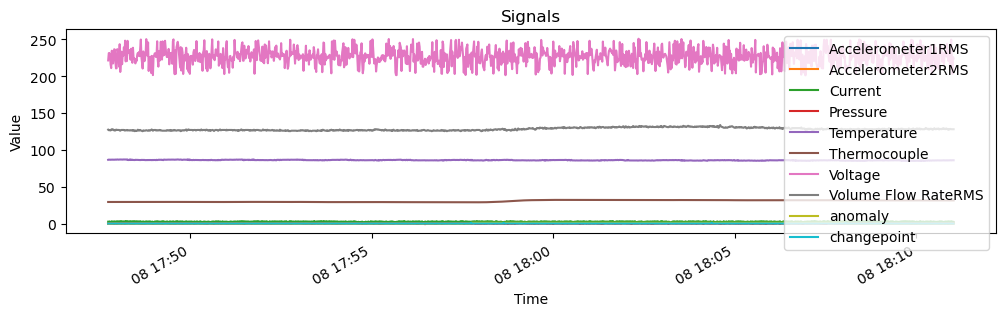

In [6]:
# random dataset visualizing
list_of_df[1].plot(figsize=(12, 3))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

### Labels visualization

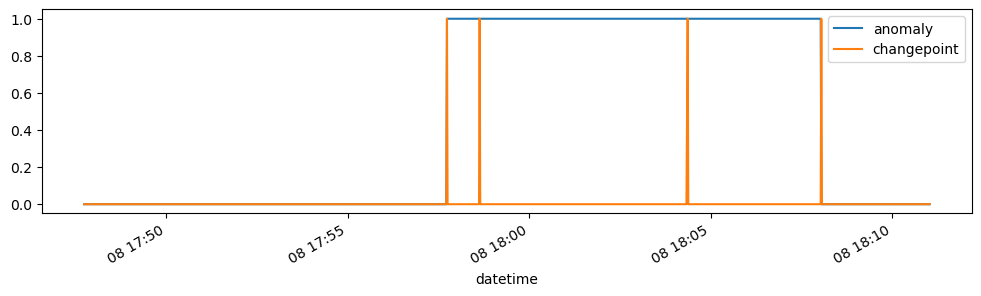

In [7]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[1].anomaly.plot(figsize=(12, 3))
list_of_df[1].changepoint.plot()
plt.legend()
plt.show()

## Method

### Method initialization

In [8]:
from Isolation_Forest import Isolation_Forest

In [9]:
# hyperparameters selection
random_state=0
n_jobs=-1
contamination=0.0005
PARAMS = [random_state, n_jobs, contamination]

In [10]:
# model defining
model = Isolation_Forest(PARAMS)

### Method fitting and applying

In [11]:
%%time
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(['anomaly','changepoint'], axis=1)
    
    # classifier fitting
    model.fit(X_train)

    # results predicting
    prediction = pd.Series(model.predict(df.drop(['anomaly','changepoint'], axis=1))*-1, 
                                index=df.index).rolling(3).median().fillna(0).replace(-1,0)
    
    # predicted outliers saving
    predicted_outlier.append(prediction)
    
    # predicted CPs saving
    prediction_cp = prediction.rolling(30).max().fillna(0).diff().abs()
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

CPU times: total: 11.2 s
Wall time: 9.85 s


### Results visualization

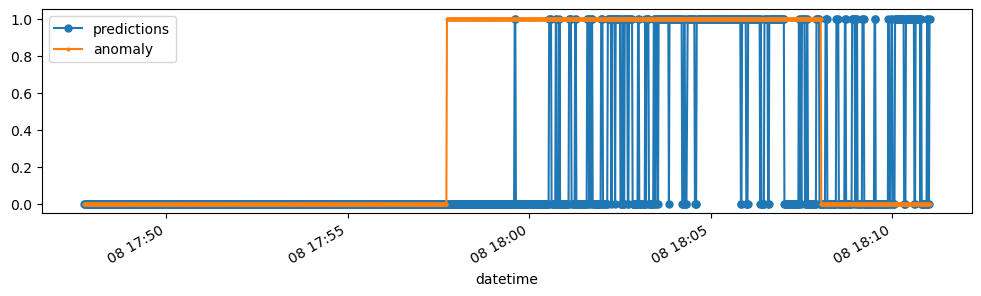

In [12]:
# true outlier indices selection
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend();

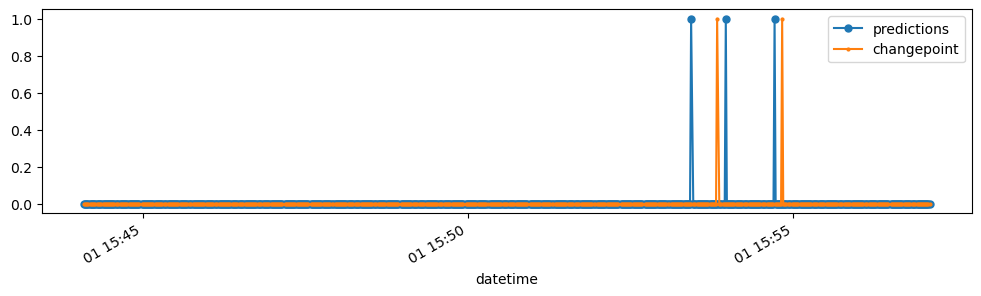

In [13]:
# true changepoint indices selection
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12,3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend();

## Evaluation (metrics calculation)

In [14]:
# 'pip install tsad' if needed
from tsad.evaluating.evaluating import evaluating

### Binary classification (outlier detection) metrics

In [15]:
# binary classification metrics calculation
binary = evaluating(
    true_outlier, 
    predicted_outlier, 
    metric='binary'
)

Since you not choose numenta_time and portion, then portion will be 0.1
False Alarm Rate 1.16 %
Missing Alarm Rate 83.28 %
F1 metric 0.28


### Changepoint detection metrics

In [16]:
# average detection delay metric calculation
add = evaluating(
    true_cp, 
    predicted_cp, 
    metric='average_time',
    anomaly_window_destenation='righter', 
    portion=1
)

Intersection of scoring windows(Timestamp('2020-03-01 15:58:10'), Timestamp('2020-03-01 15:54:50'))
Intersection of scoring windows(Timestamp('2020-02-08 18:02:23.600000'), Timestamp('2020-02-08 17:58:38'))
Intersection of scoring windows(Timestamp('2020-02-08 18:09:01.600000'), Timestamp('2020-02-08 18:08:03'))
Intersection of scoring windows(Timestamp('2020-02-08 18:24:52.800000'), Timestamp('2020-02-08 18:20:46'))
Intersection of scoring windows(Timestamp('2020-02-08 18:31:06.800000'), Timestamp('2020-02-08 18:28:37'))
Intersection of scoring windows(Timestamp('2020-02-08 18:48:51.600000'), Timestamp('2020-02-08 18:46:33'))
Intersection of scoring windows(Timestamp('2020-02-08 18:55:37.600000'), Timestamp('2020-02-08 18:51:55'))
Intersection of scoring windows(Timestamp('2020-02-08 19:01:15.800000'), Timestamp('2020-02-08 18:58:30'))
Intersection of scoring windows(Timestamp('2020-02-08 19:06:15.800000'), Timestamp('2020-02-08 19:03:36'))
Intersection of scoring windows(Timestamp('2

In [17]:
# nab metric calculation
nab = evaluating(
    true_cp, 
    predicted_cp, 
    metric='nab', 
    numenta_time='30S',
    anomaly_window_destenation='center', 
)

Intersection of scoring windows(Timestamp('2020-02-08 18:20:57'), Timestamp('2020-02-08 18:20:31'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:52'), Timestamp('2020-02-08 18:51:40'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:43'), Timestamp('2020-02-08 19:26:22'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:27'), Timestamp('2020-02-08 17:16:58'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:26'), Timestamp('2020-02-08 17:23:59'))
Standart  -  9.24
LowFP  -  1.09
LowFN  -  13.91
